In [1]:
import time
start_time=time.time()

Power Spectrum: Obtaining the 1DPSD.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.fftpack
from astropy.io import fits
import astropy.units as u
#Methods
from scipy import ndimage
from radial_data import radial_data
import radialProfile
from turbustat.statistics import PowerSpectrum 

Data

In [3]:
data=pd.read_table('datos.txt')
data.describe()

,X,Y,RV
count,330.000000,330.000000,330.000000
mean,107.280000,9.390000,-275.757688
std,12.788265,6.260324,9.697986
min,85.824000,0.000000,-296.649181
25%,96.552000,4.000000,-282.613847
50%,107.280000,9.000000,-276.070115
75%,118.008000,15.000000,-270.394313
max,128.736000,19.600000,-231.143341


Data rearrange / 2D Map

In [4]:
data_2=(data.round(2)).pivot(index='Y', columns='X', values='RV')

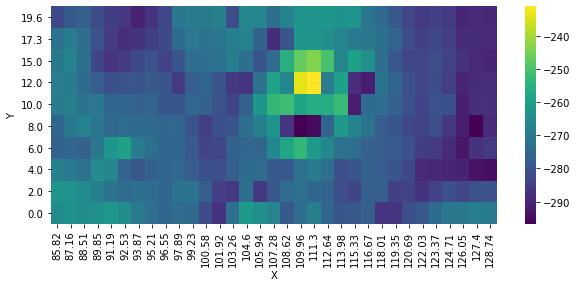

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(data_2, cmap="viridis")
plt.gca().invert_yaxis()

Recipe for the 1DPSD obtained from an image:

I) FFT on the two-dimenional data (Image) \
II) Shifting Frequency (Wavenumbers) components: Nyquist freq. at the corners.\
III) Calculate the radial average of the transformed shifted image. The startig point is the center of the image and the average is made around 'rings' having a particular distance from this point. \
IV) Plotting these averages vs wavebumbers.\

In the case of I and II) the procedure is straightforward thanks to scipy FFT library. 

For option III) we evaluate and compare different procedures: \

1) Using the ndimage sum and avergae option(https://medium.com/tangibit-studios/2d-spectrum-characterization-e288f255cc59). \
2) Doing by "hand" the ndimage stuff: Out Of the Box (OOB) Method. \
3) Using the codes radial_data and radialProfile (https://www.astrobetter.com/blog/2010/03/03/fourier-transforms-of-images-in-python/). \
4) using the Turbustat package (https://turbustat.readthedocs.io/en/latest/#). 

For option IV) the wavenumber calculation is implemented considering k=2*pi/l where l is the distance of the  averaged ring from the center.

NOTES: Methods 1,2 and 3 use as input the transformed shifted image. Method 4 use the original image.

2D Fourier Transform 

In [6]:
dataFT=data_2

In [7]:
FT2a=scipy.fftpack.fft2(dataFT)
power_s0=np.abs(FT2a)

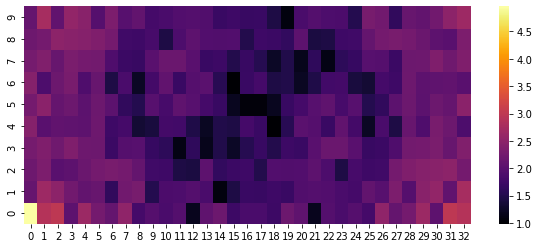

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(np.log10(power_s0), cmap="inferno")
plt.gca().invert_yaxis()

Shifted components 

In [9]:
FT2 = scipy.fftpack.fftshift(FT2a)
power_s = np.abs(FT2)**2

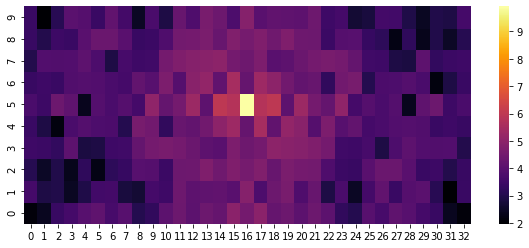

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(np.log10(power_s), cmap="inferno")
plt.gca().invert_yaxis()

Distance to components. \
Source: https://medium.com/tangibit-studios/2d-spectrum-characterization-e288f255cc59

Create an array of "rings" parting from the center of the image. 

In [11]:
h  = power_s.shape[0]
w  = power_s.shape[1]
wc = w//2
hc = h//2

In [12]:
# create an array of integer radial distances from the center
Y, X = np.ogrid[0:h, 0:w]
r    = np.hypot(X - wc, Y - hc).astype(np.int)
rdf=pd.DataFrame(r)

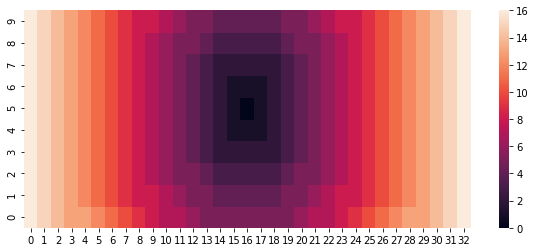

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(rdf)
plt.gca().invert_yaxis()

Radial Average Methods

ndimage.sum

In [14]:
# SUM all psd2D pixels with label 'r' for 0<=r<=wc
psd1D_sx= ndimage.sum(power_s, r, index=np.arange(0, wc))

In [15]:
psd1D_sx

array([8.28100182e+09, 2.42843155e+06, 2.65389375e+06, 9.62238213e+05,
       1.27756636e+06, 9.87631635e+05, 4.11237889e+05, 4.78550924e+05,
       2.04786841e+05, 8.18452364e+04, 1.42469249e+05, 1.23778117e+05,
       1.30456150e+05, 1.47935575e+05, 8.93410187e+04, 4.03053338e+04])

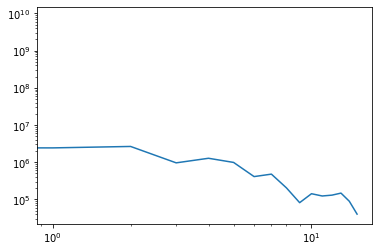

In [16]:
plt.loglog(psd1D_sx)

ndimage.mean

Now we do, the average of the "rings" (ndiamge.mean instead of sum). 

In [17]:
# SUM all psd2D pixels with label 'r' for 0<=r<=wc
psd1D_mx= ndimage.mean(power_s, r, index=np.arange(0, wc))

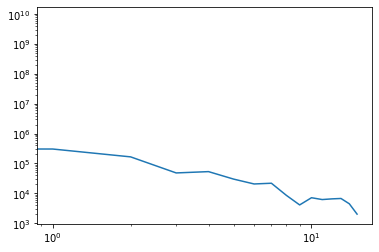

In [18]:
plt.loglog(psd1D_mx)

OBB sum

Out of the Black-Box method (OBB)

Same as above for ndimage.sum and ndimage.mean but doing all the procedure by "hand" to obtain the error. The same array of rings is used as above.

In [19]:
psdf=pd.DataFrame(power_s)
data_ps=dict()

In [20]:
for i in range(wc):
    m=(rdf==i)
    psm=(psdf[m].fillna(0)).to_numpy()
    s=psm.sum()
    err=psm.std()/np.sqrt(len(psm)-1)
    data_ps[i]=[i,s,err]
    
psd1D_2x=pd.DataFrame(data_ps).T

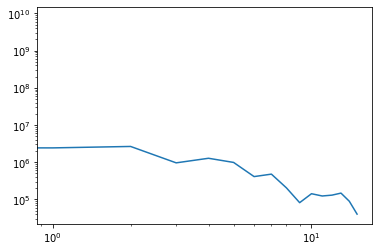

In [21]:
plt.loglog(psd1D_2x[1])

OBB mean

Doing now the average...

In [22]:
for i in range(wc):
    m=(rdf==i)
    psm=psdf[m]
    s=(psm.mean()).mean()
    err=(psm.std()/np.sqrt(len(psm))).mean()
    data_ps[i]=[i,s,err]
    
psd1D_2mx=pd.DataFrame(data_ps).T


In [23]:
#plt.plot(psd1D_2mx[1])

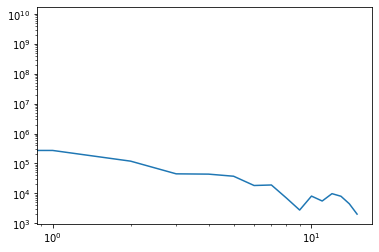

In [24]:
plt.loglog(psd1D_2mx[1])

radialProfile 
Source: https://www.astrobetter.com/wiki/tiki-index.php?page=python_image_fft

In [25]:
psd1D_x1= radialProfile.azimuthalAverage(power_s)
rp=psd1D_x1   

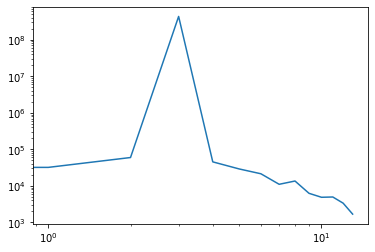

In [26]:
plt.loglog(rp)

radial_data 
Source: https://www.astrobetter.com/wiki/tiki-index.php?page=python_image_fft

In [27]:
psd1D_x2=radial_data(power_s,annulus_width=1,working_mask=None,x=None,y=None,rmax=None)
rv=psd1D_x2.mean

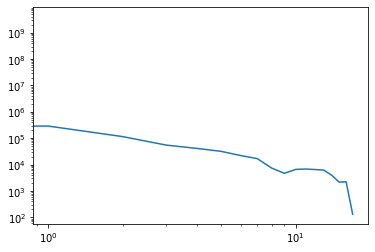

In [28]:
plt.loglog(rv)

Turbustat

https://turbustat.readthedocs.io/en/latest/tutorials/statistics/pspec_example.html

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\turbustat\statistics\elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     54.33
Date:                Thu, 10 Sep 2020   Prob (F-statistic):           1.58e-06
Time:                        05:09:22   Log-Likelihood:               -0.56080
No. Observations:                  18   AIC:                             5.122
Df Residuals:                      16   BIC:                             6.902
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0938      0.178     17.338      0.0

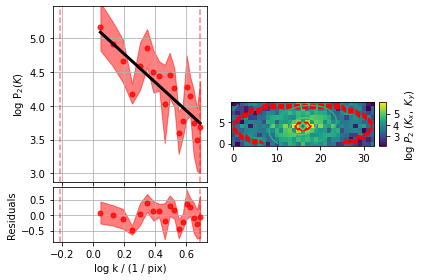

In [29]:
powerfits=fits.PrimaryHDU(dataFT)
pspec=PowerSpectrum(powerfits, distance=840000*u.pc)
pspec.run(verbose=True,use_wavenumber=True)

In [30]:
print(pspec.slope2D,pspec.slope2D_err)

-2.0414050059091218 0.17000708541361154


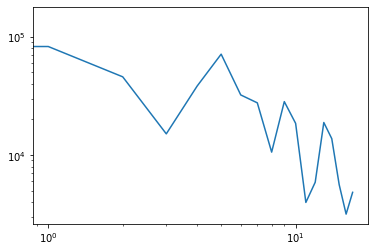

In [31]:
plt.loglog(pspec.ps1D)

Comparison

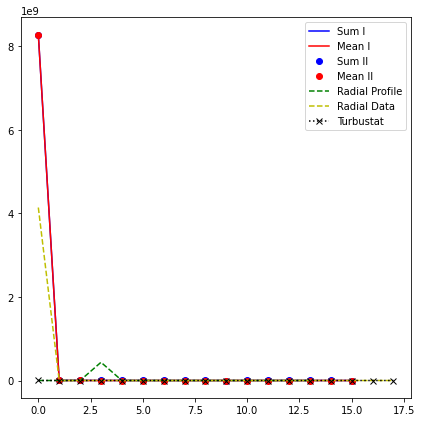

In [32]:
fig, ax = plt.subplots(figsize=(7, 7))


plt.plot(psd1D_sx, 'b-', label='Sum I')
plt.plot(psd1D_mx, 'r-', label='Mean I')
plt.plot(psd1D_2x[1], 'bo', label='Sum II')
plt.plot(psd1D_2mx[1], 'ro', label='Mean II')
plt.plot(rp, '--g', label='Radial Profile')
plt.plot(rv, '--y', label='Radial Data')
plt.plot(pspec.ps1D, 'xk:', label='Turbustat')

plt.legend()

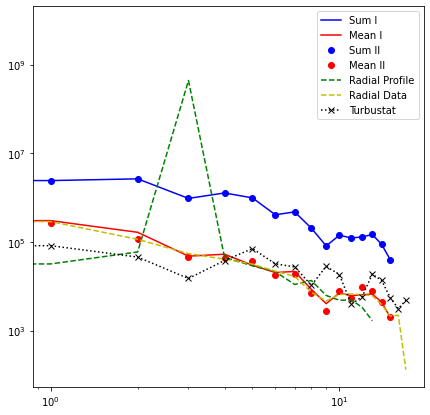

In [33]:
fig, ax = plt.subplots(figsize=(7, 7))


plt.loglog(psd1D_sx, 'b-', label='Sum I')
plt.loglog(psd1D_mx, 'r-', label='Mean I')
plt.loglog(psd1D_2x[1], 'bo', label='Sum II')
plt.loglog(psd1D_2mx[1], 'ro', label='Mean II')
plt.loglog(rp, '--g', label='Radial Profile')
plt.loglog(rv, '--y', label='Radial Data')
plt.loglog(pspec.ps1D, 'xk:', label='Turbustat')

plt.legend()

Wavenumber calculation

In [34]:
#psd1D_2mxx = psd1D_2mx.iloc[1:]

In [35]:
dfx=dataFT.stack().reset_index().rename(columns={'level_1':'X','level_0':'Y', 0:'RV'})

In [36]:
data.X.max()-data.X.min()

42.91199999999999

In [37]:
dfx.X[1]-dfx.X[0]

1.3400000000000034

In [38]:
x=np.linspace(data.X.max()-data.X.min(),dfx.X[1]-dfx.X[0],len(psd1D_2mx))
x=(2*np.pi)/x
x

array([0.14642024, 0.15652969, 0.16813867, 0.18160755, 0.1974222 ,
       0.21625391, 0.23905709, 0.26723616, 0.30294622, 0.34967195,
       0.41343999, 0.50565369, 0.65081054, 0.91286447, 1.5282102 ,
       4.68894426])

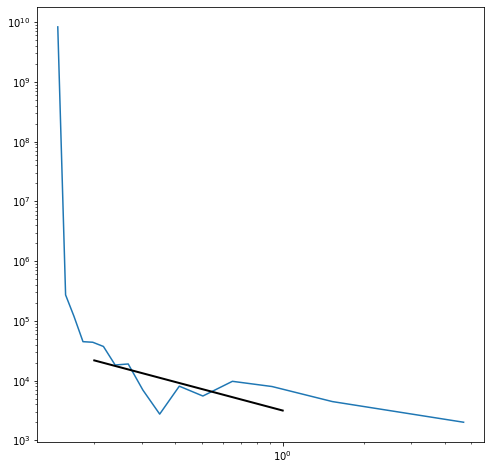

In [39]:
fig, ax=plt.subplots(figsize=(8,8))
plt.loglog(x,psd1D_2mx[1])
sgrid = np.linspace(0.2, 1)
ax.plot(sgrid, 10**3.5*sgrid**(-1.2), color="k", lw=2)

1DPSD

In [40]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 13.6610746383667 seconds ---
